# Obligatorio de Análisis Predictivo de Series Temporales


## Conteo de vehículos

## Estudiantes: Felipe Bastarrica y Emiliano Espíndola


In [89]:
#install.packages("data.table")                             # Install data.table package
#cargo bibliotecas
library(astsa)
library(forecast)
library("data.table") 

#ajusto tamaño de gráficas
options(repr.plot.width=15, repr.plot.height=8)

## Carga de datos

In [90]:
# Datos extraidos de https://catalogodatos.gub.uy/dataset/intendencia-montevideo-conteo-de-vehiculos-del-centro-de-gestion-de-la-movilidad

# Carga de datos preprocesados - Son datos para la calle Sarmiento de rambla a 
# requena del 1-1-2017 al 31-12-2018 sumarizado en 3 detectores sin contar sabados y domingos.
df <- read.csv("./volumen_Sarmiento_15_2017_092019.csv", )

# Dataframe con los datos crudos obtenidos cada 5 minutos de cada sensor de carril
df_raw = read.csv("./2017_2018_raw.csv", sep =";")
head(df_raw)
tail(df_raw)

,date,volumen
,<chr>,<int>
1,1/1/17 00:00,0
2,1/1/17 00:00,0
3,1/1/17 00:00,0
4,1/1/17 00:05,0
5,1/1/17 00:05,0
6,1/1/17 00:05,0


,date,volumen
,<chr>,<int>
307837,31/12/17 23:50,0
307838,31/12/17 23:50,3
307839,31/12/17 23:50,0
307840,31/12/17 23:55,0
307841,31/12/17 23:55,3
307842,31/12/17 23:55,0


## Definición de frecuencias

In [91]:
weekend_days = 0

# Frecuencia de muestreo por 15 min
#freq = ((365-weekend_days)*24*60)/(3*5)
freq = ((365-weekend_days)*24*60)/(5)
freq_aux = ((365-weekend_days)*24*60)/(3*5*(365/7))

In [92]:
# Definición de Time Series
#df_ts = ts(df$volumen, frequency=freq, start=c(2017,1))
#df_ts_aux = ts(df$volumen, frequency=freq_aux, start=c(2017,10))


### Primer estudio de los datos

Se convierte a una serie de tiempo los datos cargados, sumarizándolos cada 15 minutos.

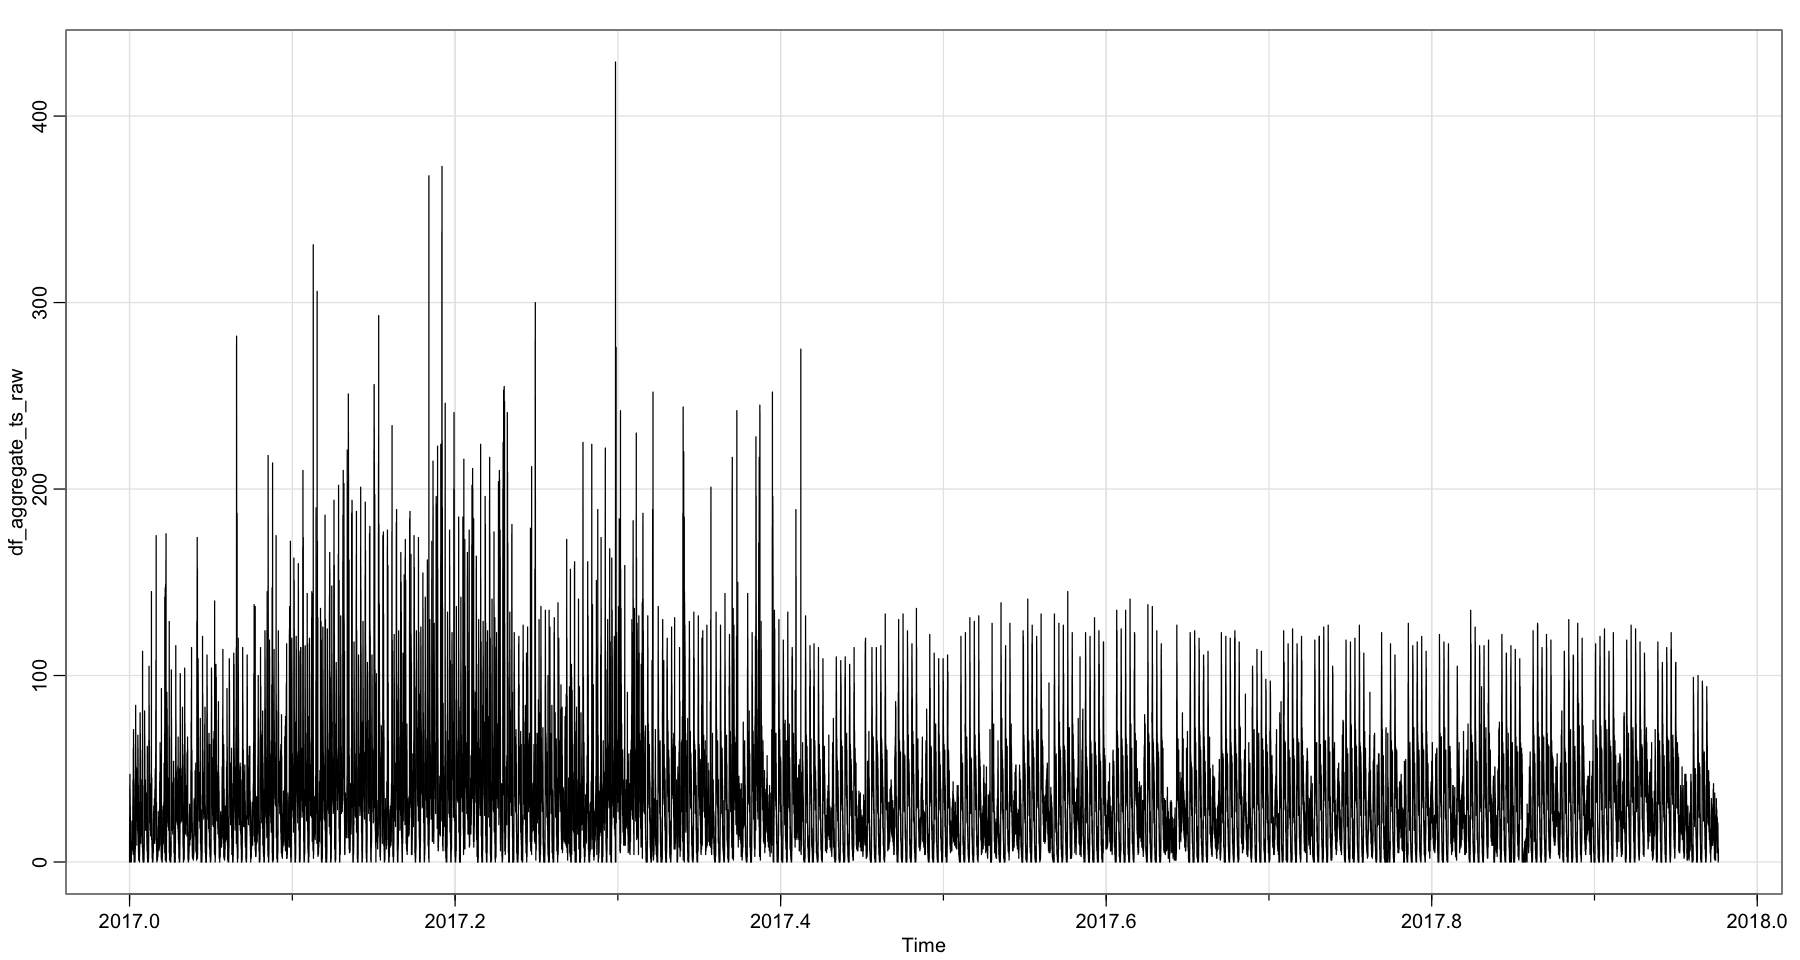

In [93]:
df_ts_aux_raw = ts(df_raw$volumen, frequency=freq, start=c(2017,1))
df_aggregate_raw = aggregate(df_ts_aux_raw, nfrequency = freq/3, FUN = sum)
df_aggregate_ts_raw = ts(df_aggregate_raw, frequency = freq, start=c(2017,1))

# Plot de la TS
tsplot(df_aggregate_ts_raw) # ESTE ERA SIN COMPLETAR!

Analizando la TS, se nota la falta de entradas por no llegar a completar el año entero en tiempo, se "apretaron" los datos en las absisas. Se procede a completar estos datos faltantes con NAs.

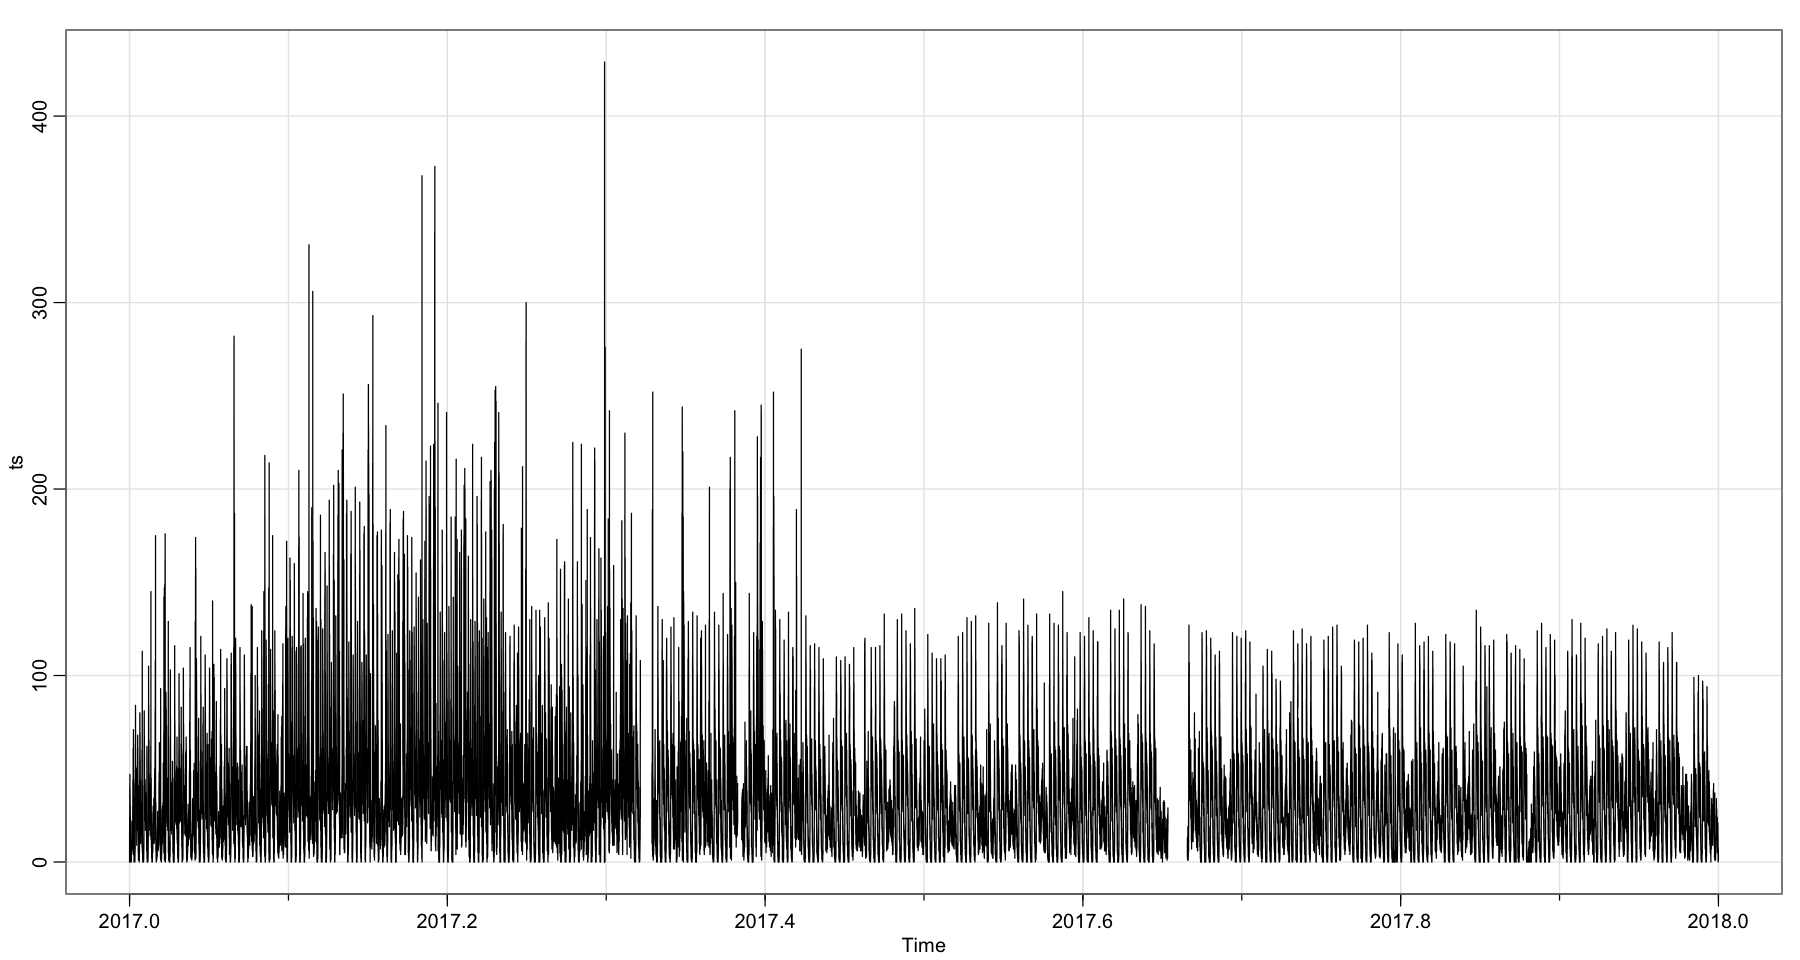

In [94]:
# Copia de dataframe original
originaldf <- df_raw

# Creación de nueva columna para new date
originaldf$minAsPOSIX <- as.POSIXct(originaldf$date, format="%d/%m/%y %H:%M",tz="GMT")

# Generación del vector para cada 5 minutos
ndays <- 365 # días a generar
minAsNumeric <-seq(0,60*60*24*ndays,by=5*60) # de 0 a 365 días en segundos con un paso de 5 minutos

# Conversión de secuencia a posix (formato calendario)
minAsPOSIX <- as.POSIXct(minAsNumeric, origin="2017-01-01", tz="GMT")

# Columna con datos calendario para 1 año 
base_df = data.frame(minAsPOSIX)

# Merge de datos calendario completos con los datos de volumen original
df_merged <- merge(base_df,originaldf,all.x=TRUE, by="minAsPOSIX")
     
# Agregación de datos de volumen por 
newdf = aggregate(df_merged$volumen, by=list(Date=df_merged$minAsPOSIX), FUN=sum)
colnames(newdf) <- c('date','volumen')

ts = ts(newdf$volumen, frequency=freq, start=c(2017,1))
tsplot(ts)

Ahora se obtiene un nuevo dataframe donde en la primer columna están los datos ***date*** de fecha completos en todo el tiempo deseado sin huecos y con su correspondiente sumarización en la columna ***volumen***. Donde haya habido un dato faltante, se colocó NA.

Acortamos la serie en una nueva de menos días para ver su comportamiento mas al detalle.

[1] "Media: 25.5530753968254"


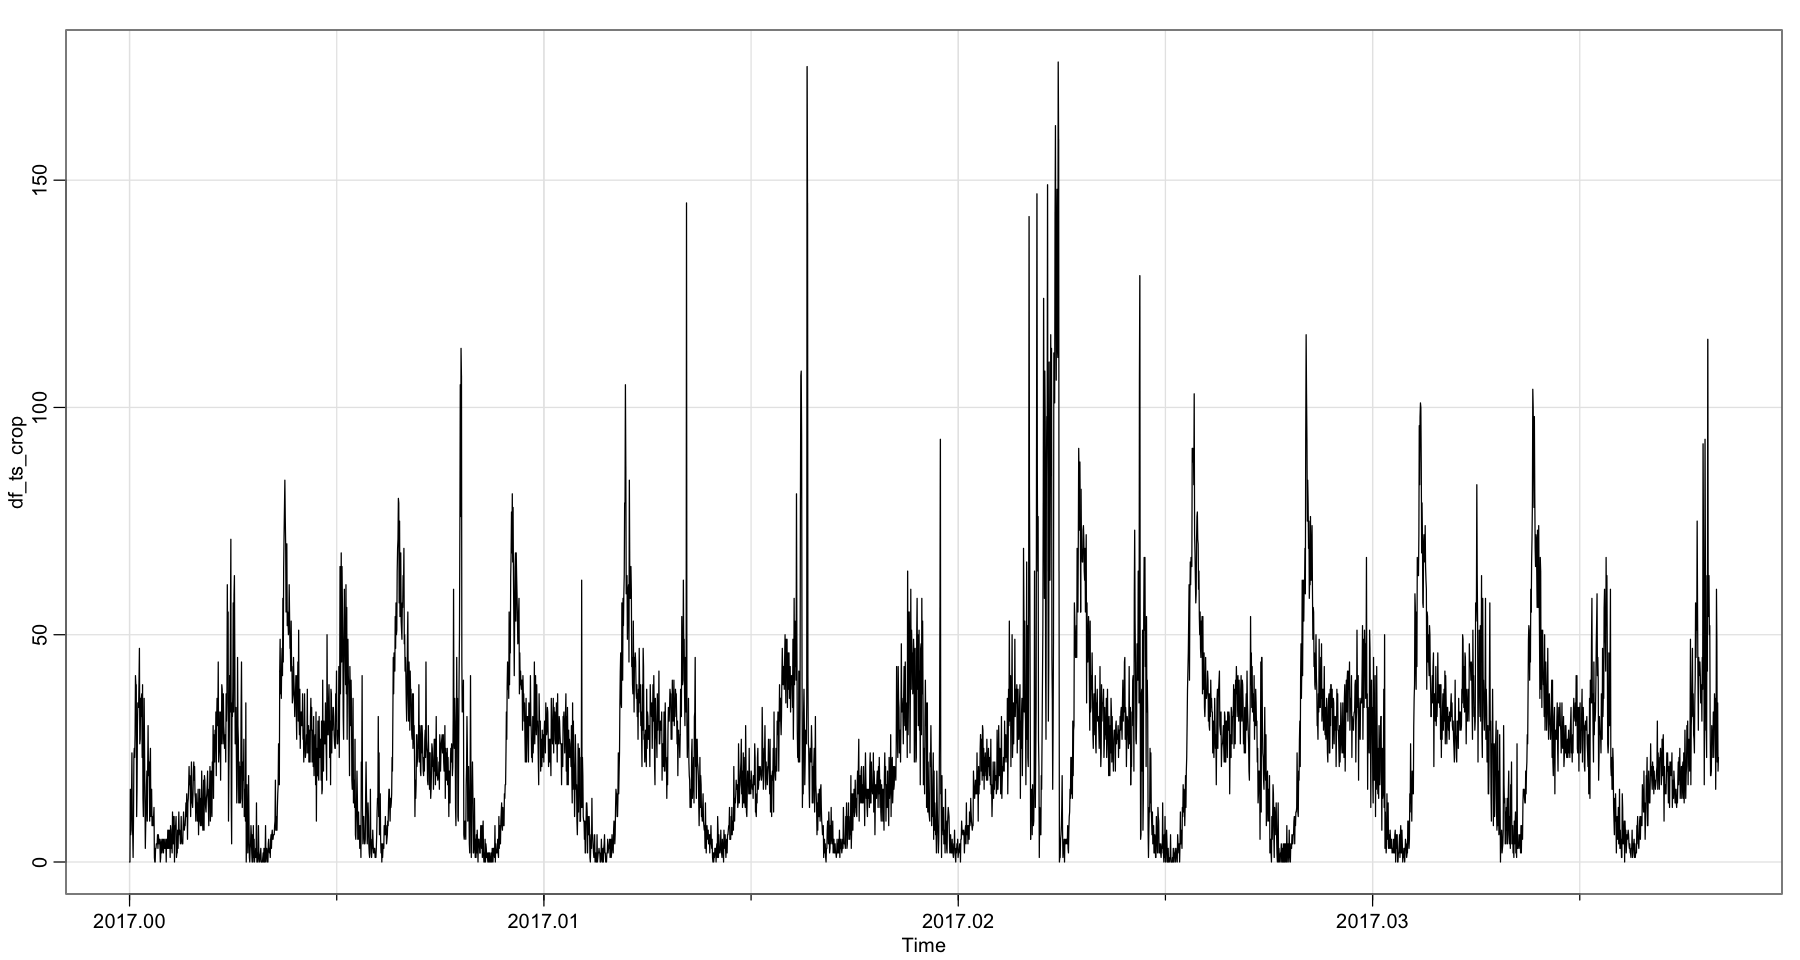

In [109]:
# Días a tomar para análisis más pequeño
days_to_crop = 14

# Muestras por día (1 muestra cada 5 minutos x 24)
samples_per_day = 60/5*24

# Serie recortada
df_ts_crop = head(ts, samples_per_day*days_to_crop)

# Promedio de serie cortada
print(paste("Media:", mean(df_ts_crop)))

# Plot de la serie cortada
tsplot(df_ts_crop)


Se superponen las series semanalmente para ver su comportamiento.

In [110]:
# Nuevo dataframe agregado 
ts_aggregate = aggregate(ts, nfrequency = freq/3, FUN = sum) #Se pasa a 15 minutos
head(ts_aggregate)
ts_aggregate_ts_croped = head(ts_aggregate, (4*24*5))
print(paste("Largo de ts_aggregate_ts_croped:", length(ts_aggregate_ts_croped)))
print(paste("Frecuencia de ts_aggregate_ts_croped:", frequency(ts_aggregate_ts_croped)))

A Time Series:
[1]  16  31  37  33  76 119

[1] "Largo de ts_aggregate_ts_croped: 480"
[1] "Frecuencia de ts_aggregate_ts_croped: 35040"


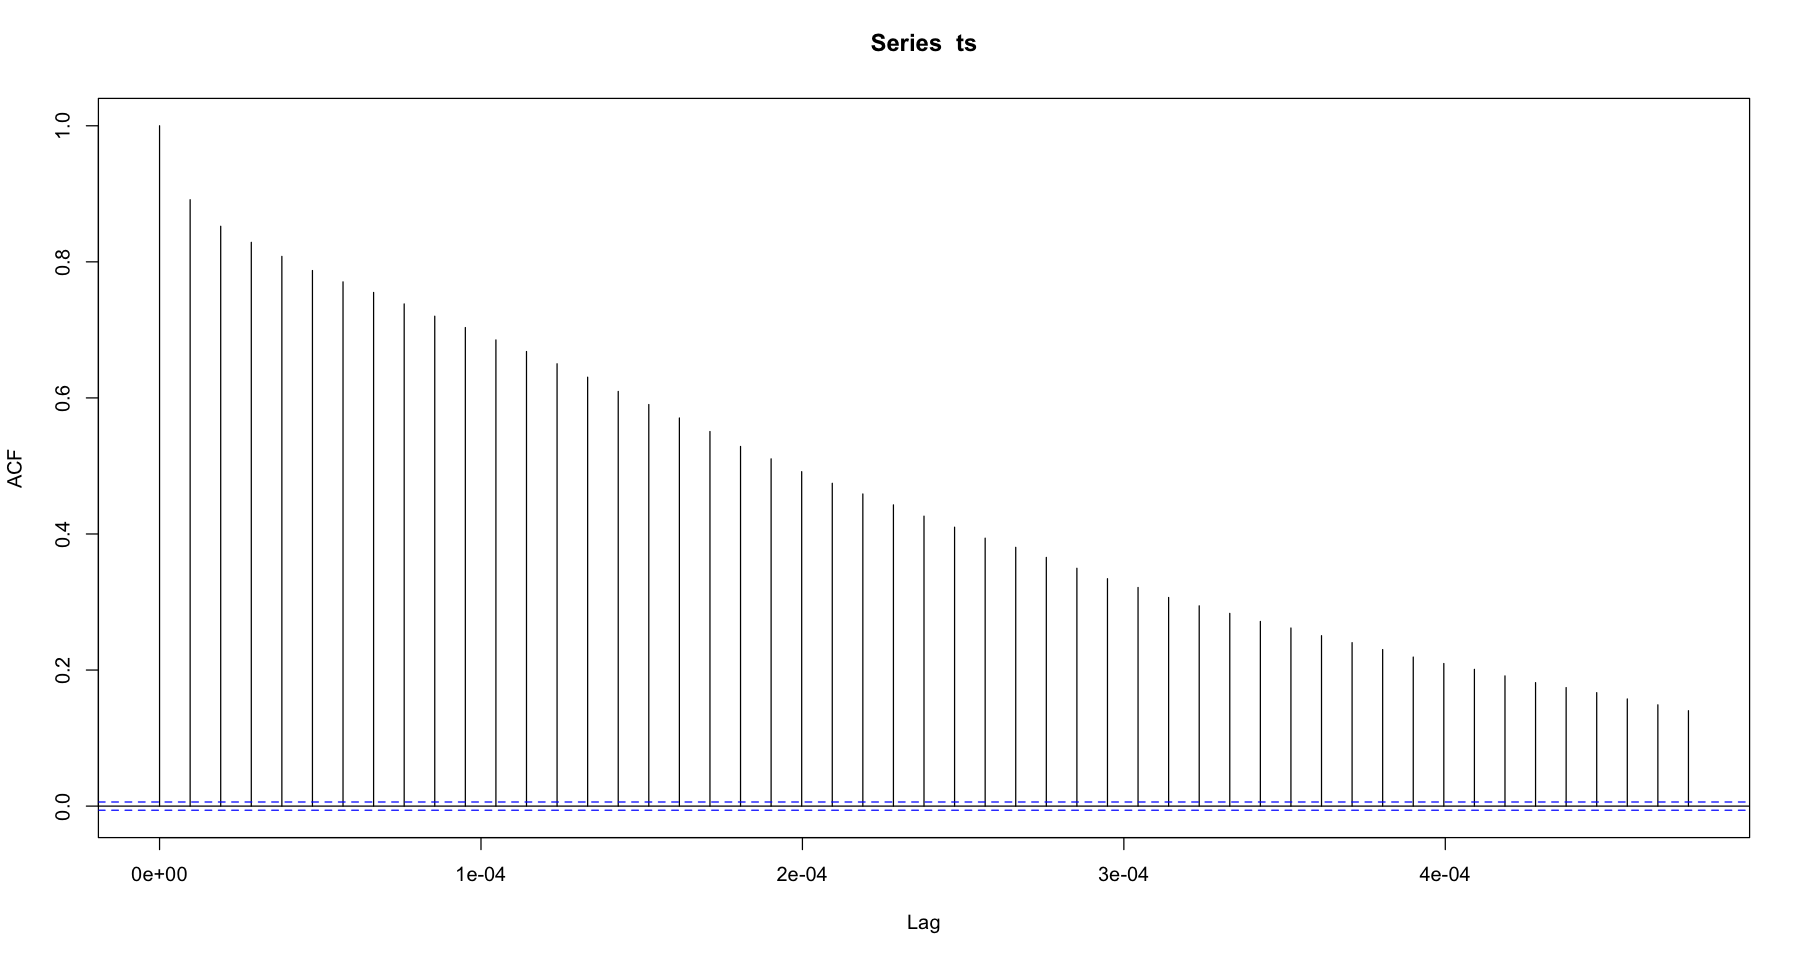

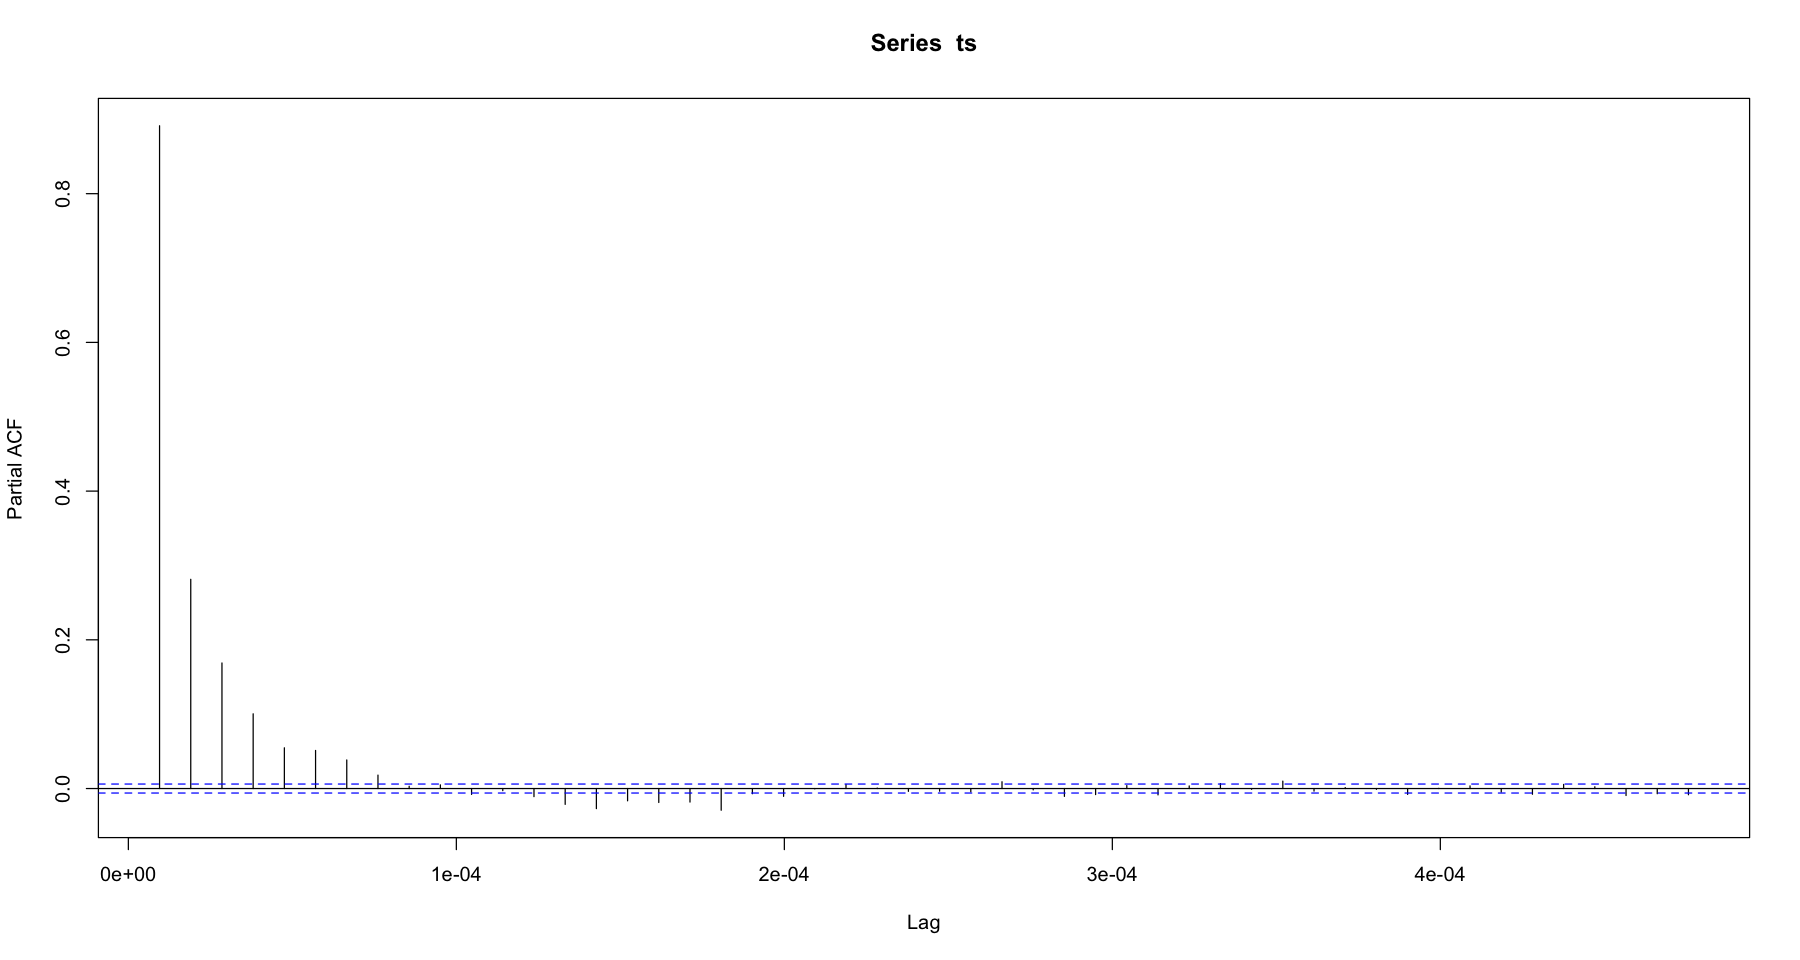

In [111]:
acf(ts, na.action = na.pass)
pacf(ts, na.action = na.pass)

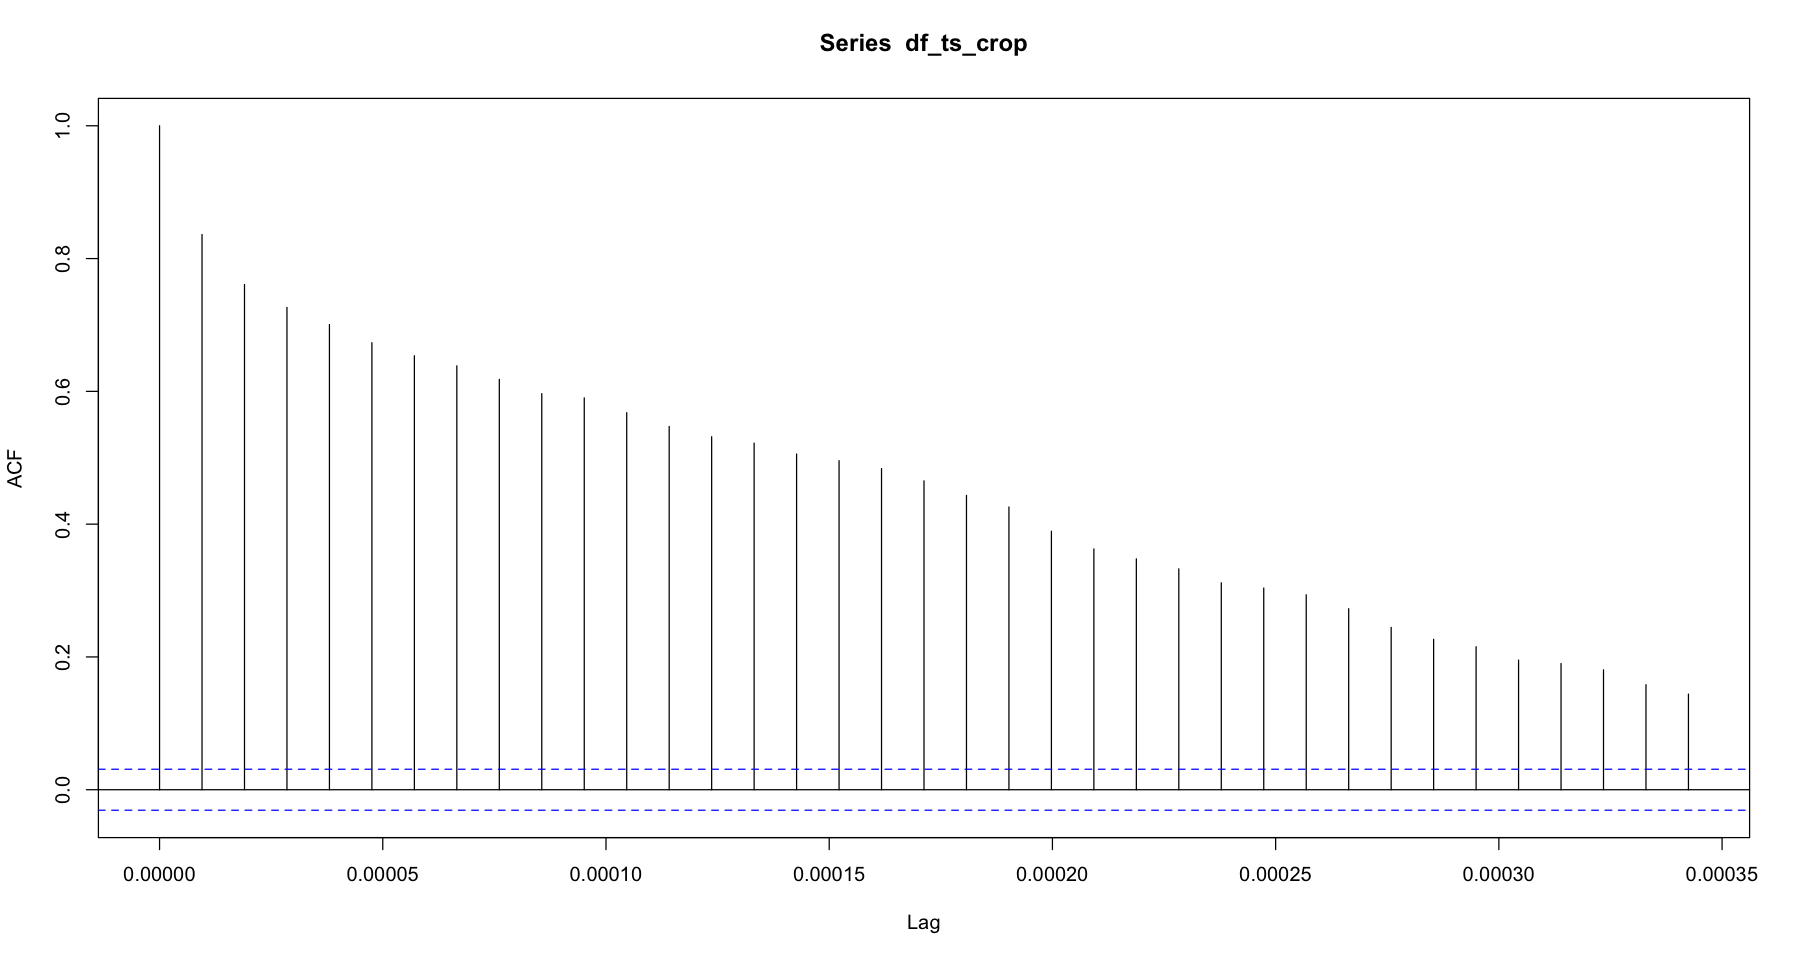

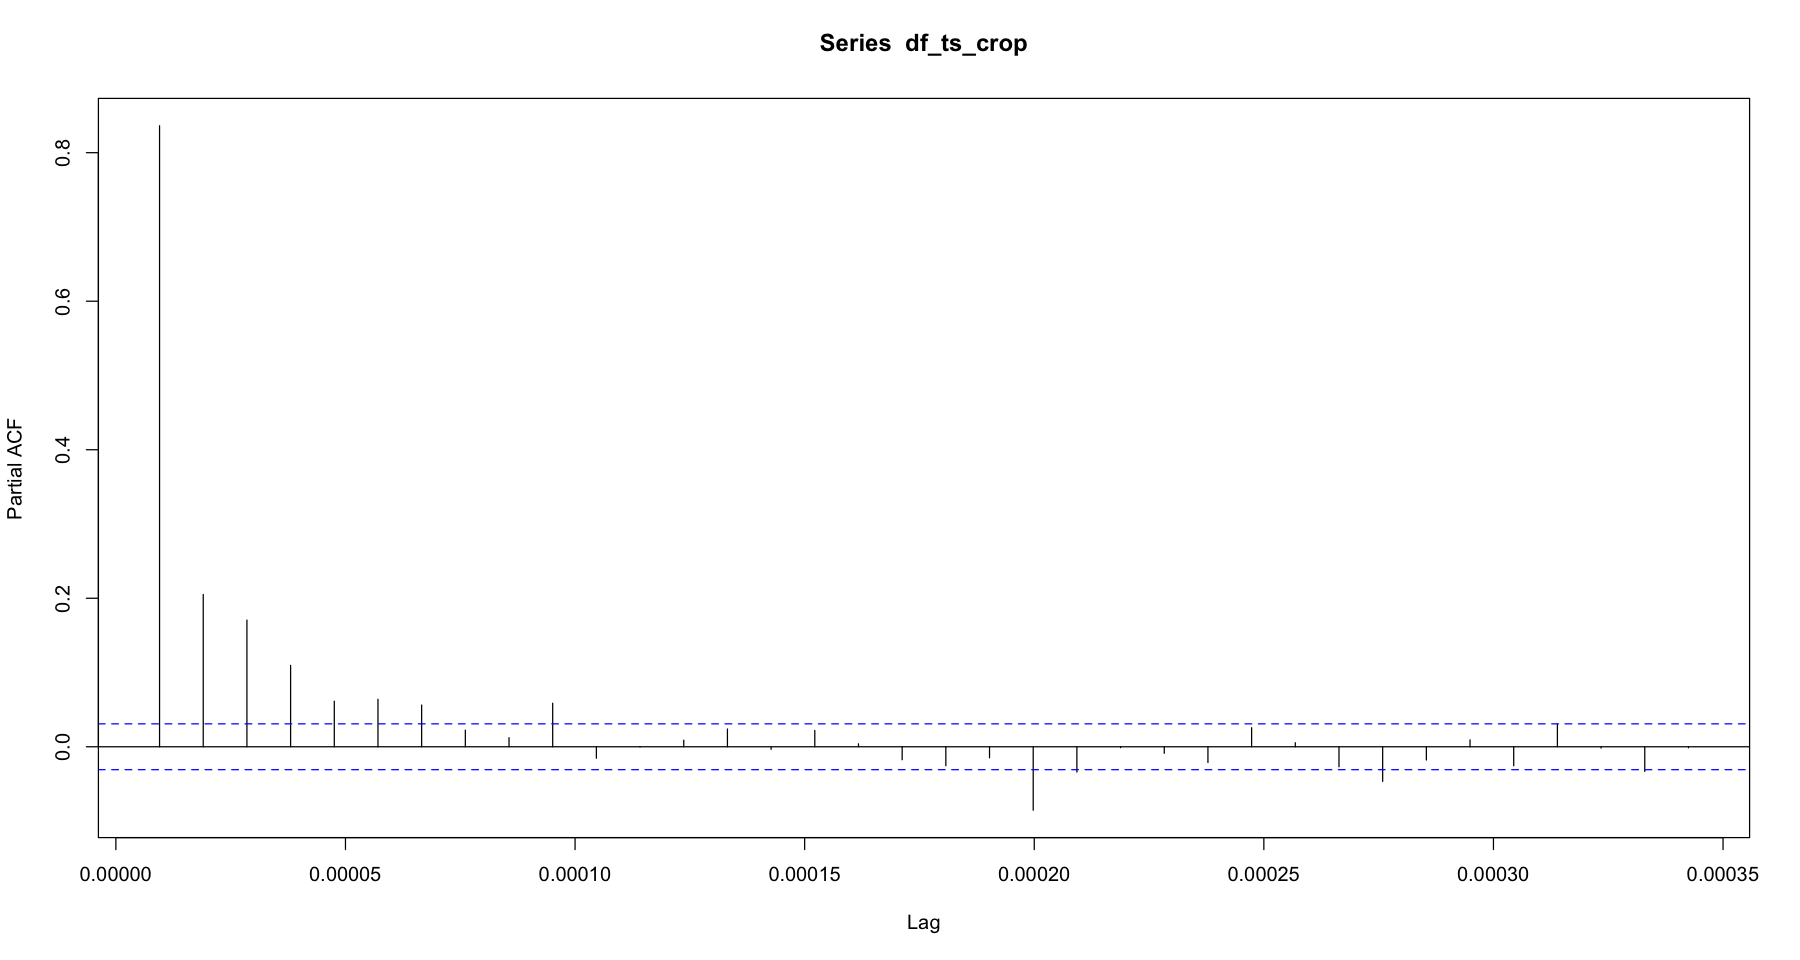

In [112]:
acf(df_ts_crop, na.action = na.pass)
pacf(df_ts_crop, na.action = na.pass)

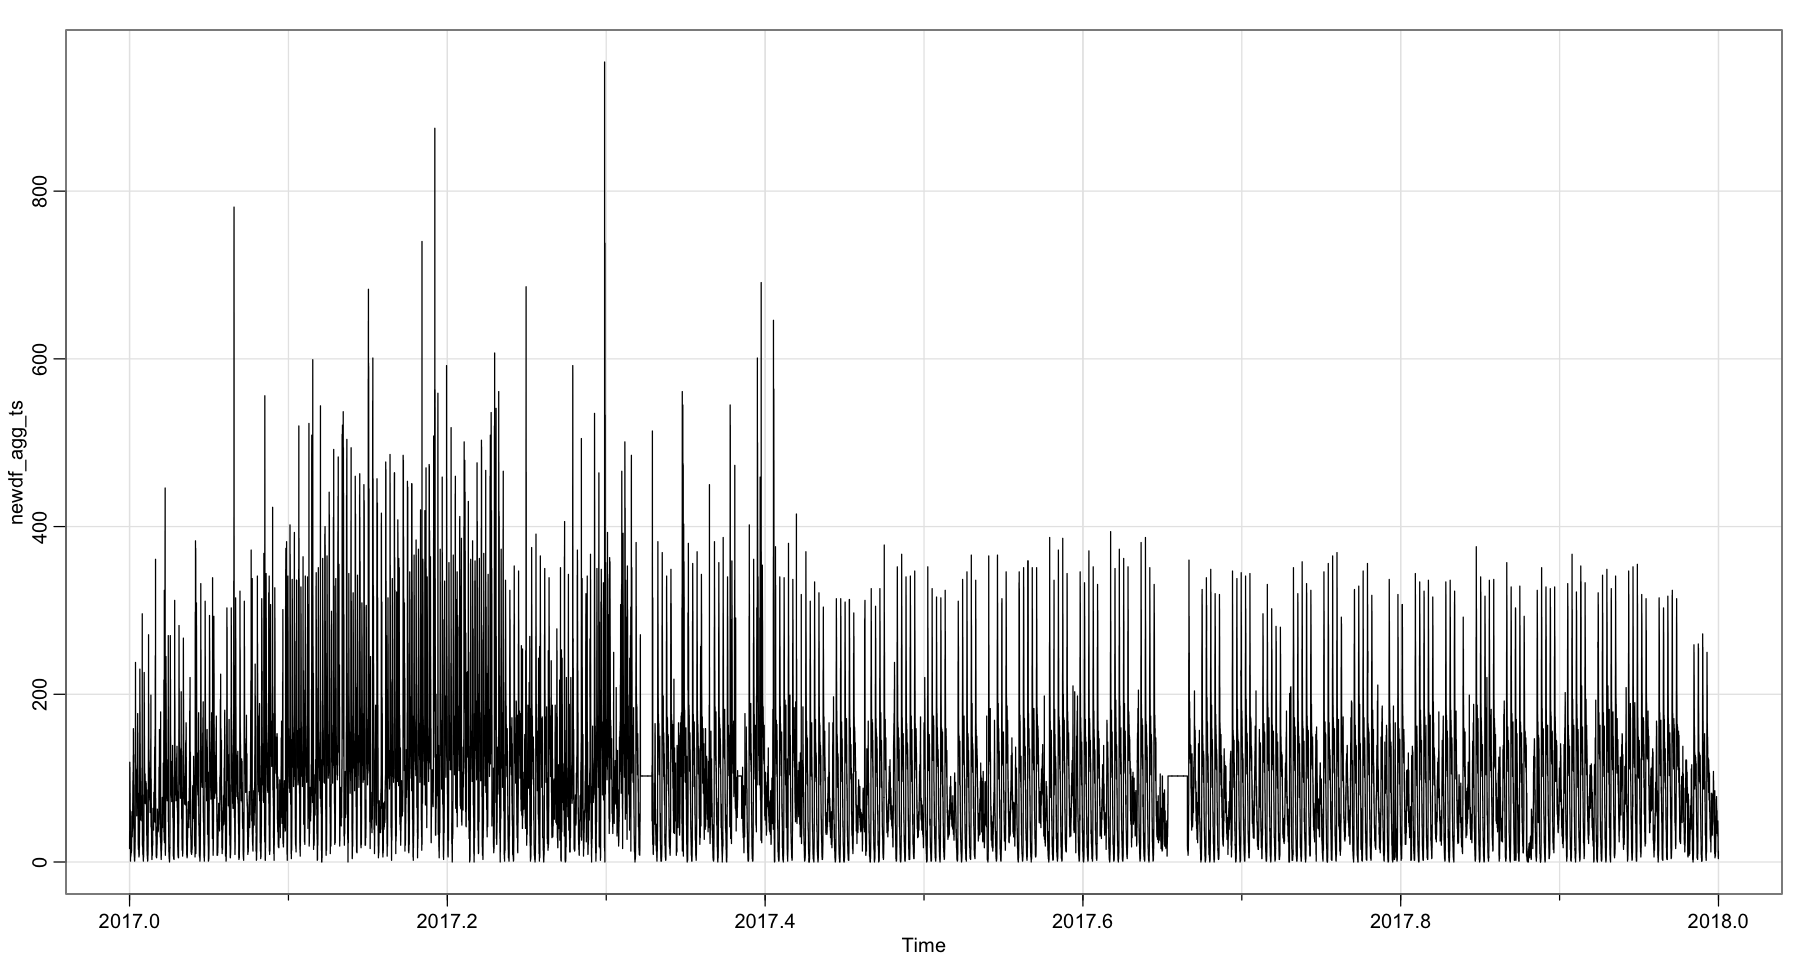

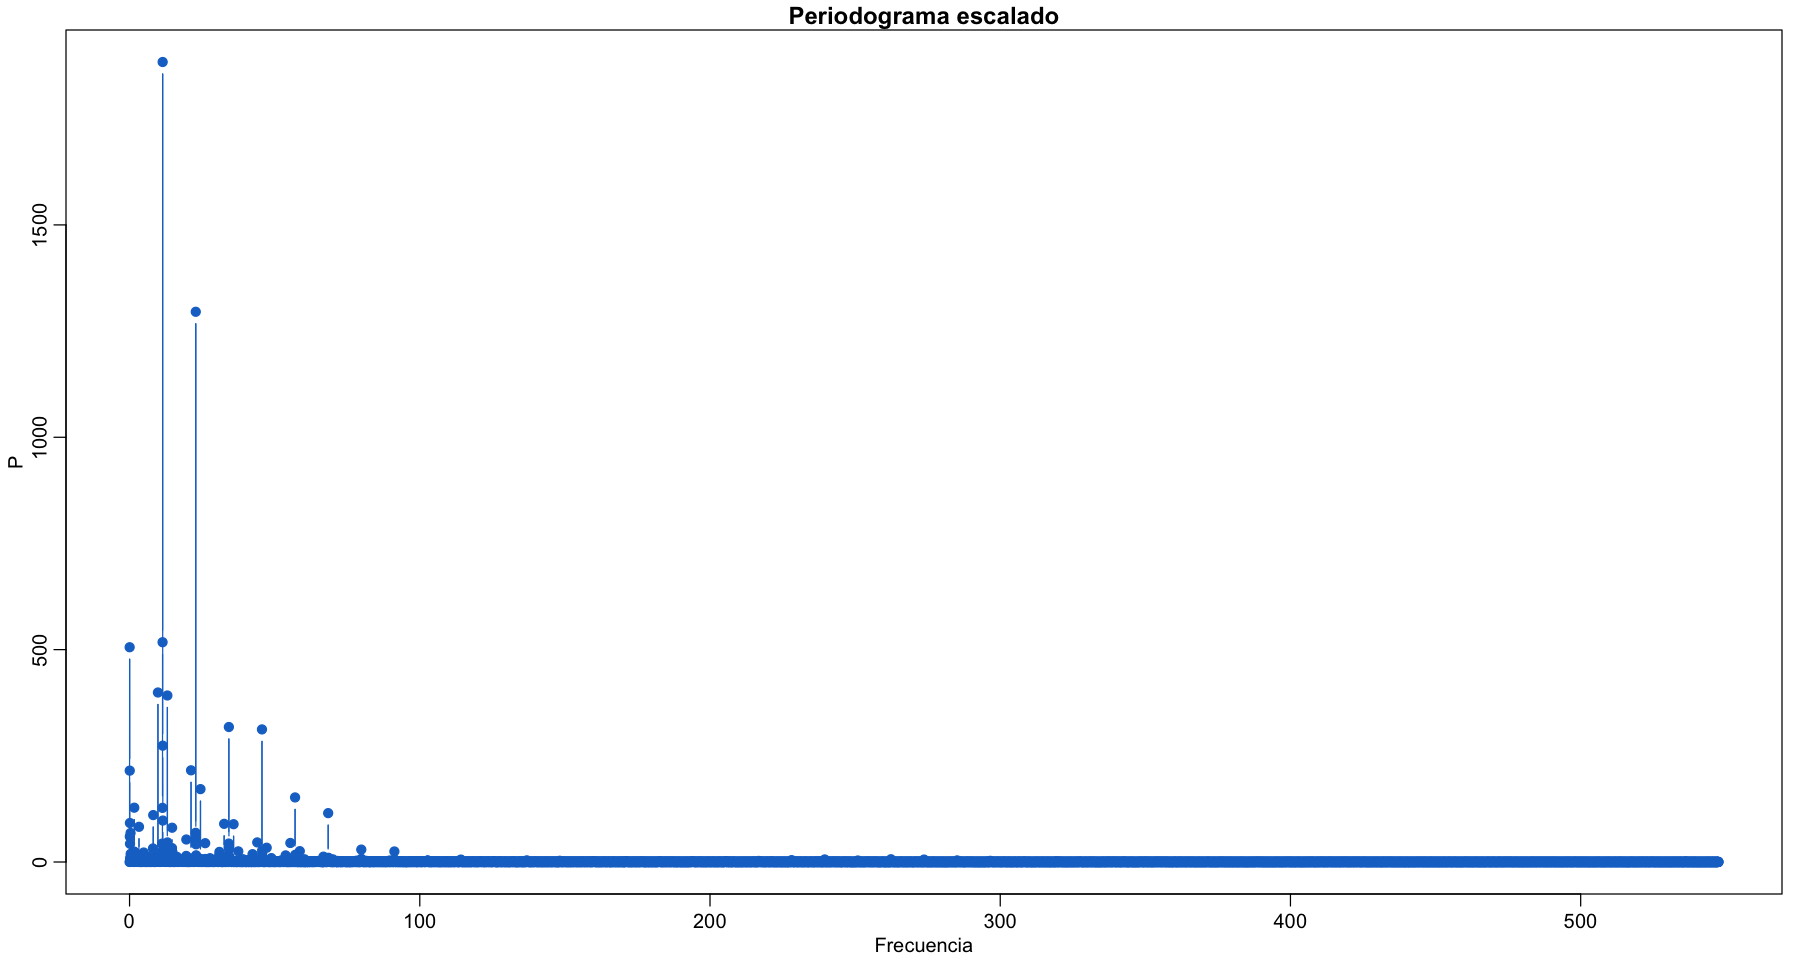

In [113]:
# Estudio de la periodicidad 
#freq_periodograma = (24*60)/(3*5) # 24 horas * 60 minutos es la granularidad de minutos por día * 5 minutos por muestra agregado en 3 muestras 

# Cambiar NAs por media
data1 <- newdf                                             # Duplicate data frame
data1$volumen[is.na(data1$volumen)] <- mean(data1$volumen, na.rm = TRUE)  # Replace NA in one column
data1_ts = ts(data1$volumen, frequency=freq, start=c(2017,1))

# Agregar datos a muestras de 15 minutos
newdf_agg_ts = aggregate(data1_ts, nfrequency = freq/3, FUN = sum)
#newdf_agg_ts = ts(newdf_agg, frequency=freq/3, start=c(2017,1))
tsplot(newdf_agg_ts)
s = newdf_agg_ts
s = s-mean(s) # Se quita la media
n = length(s)
I = abs(fft(s))^2 #FFT y módulo cuadrado
I = I[1:floor(n/2)] #Recorto el vector a las frecuencias observables
P = (4/n^2)*I #Escalado del periodograma
f = (0:(n/2-1))/n*(freq/96) #Vector de frecuencias para hacer el gráfico (se multiplica por la frecuencia de la serie, para normalizar

#Ploteo del periodograma
plot(f, P, type="b", xlab="Frecuencia", main="Periodograma escalado", col=4, lwd=1, pch=19)


In [114]:
samples_per_day = 96
# Primera frecuencia de mayor importancia
f1 = f[which.max(P)]*samples_per_day/3
print(paste("f1:",f1))
print(paste("which.max(P1):",which.max(P)))

# Segunda frecuencia de mayor importancia
P[which.max(P)] = 0
f2 = f[which.max(P)]*samples_per_day/3
print(paste("f2:",f2))
print(paste("which.max(P2):",which.max(P)))

# Tercera frecuencia de mayor importancia
P[which.max(P)] = 0
f3 = f[which.max(P)]*samples_per_day/3
print(paste("f3:",f3))
print(paste("which.max(P3):",which.max(P)))

# Cuarta frecuencia de mayor importancia
P[which.max(P)] = 0
f4 = f[which.max(P)]*samples_per_day/3
print(paste("f4:",f4))
print(paste("which.max(P4):",which.max(P)))

# Quinta frecuencia de mayor importancia
P[which.max(P)] = 0
f5 = f[which.max(P)]*samples_per_day/3
print(paste("f5:",f5))
print(paste("which.max(P5):",which.max(P)))

[1] "f1: 365"
[1] "which.max(P1): 366"
[1] "f2: 730"
[1] "which.max(P2): 731"
[1] "f3: 364"
[1] "which.max(P3): 365"
[1] "f4: 1"
[1] "which.max(P4): 2"
[1] "f5: 313"
[1] "which.max(P5): 314"



Call:
lm(formula = newdf_agg_ts ~ t + cos(2 * pi * f1 * t) + sin(2 * 
    pi * f1 * t) + cos(2 * pi * f2 * t) + sin(2 * pi * f2 * t))

Residuals:
    Min      1Q  Median      3Q     Max 
-171.78  -42.86  -12.86   25.02  918.94 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          82788.582   2693.132   30.74   <2e-16 ***
t                      -40.984      1.335  -30.70   <2e-16 ***
cos(2 * pi * f1 * t)   -39.636      0.545  -72.73   <2e-16 ***
sin(2 * pi * f1 * t)   -17.717      0.545  -32.51   <2e-16 ***
cos(2 * pi * f2 * t)     7.688      0.545   14.11   <2e-16 ***
sin(2 * pi * f2 * t)   -35.180      0.545  -64.55   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 72.13 on 35034 degrees of freedom
Multiple R-squared:  0.2495,	Adjusted R-squared:  0.2494 
F-statistic:  2329 on 5 and 35034 DF,  p-value: < 2.2e-16


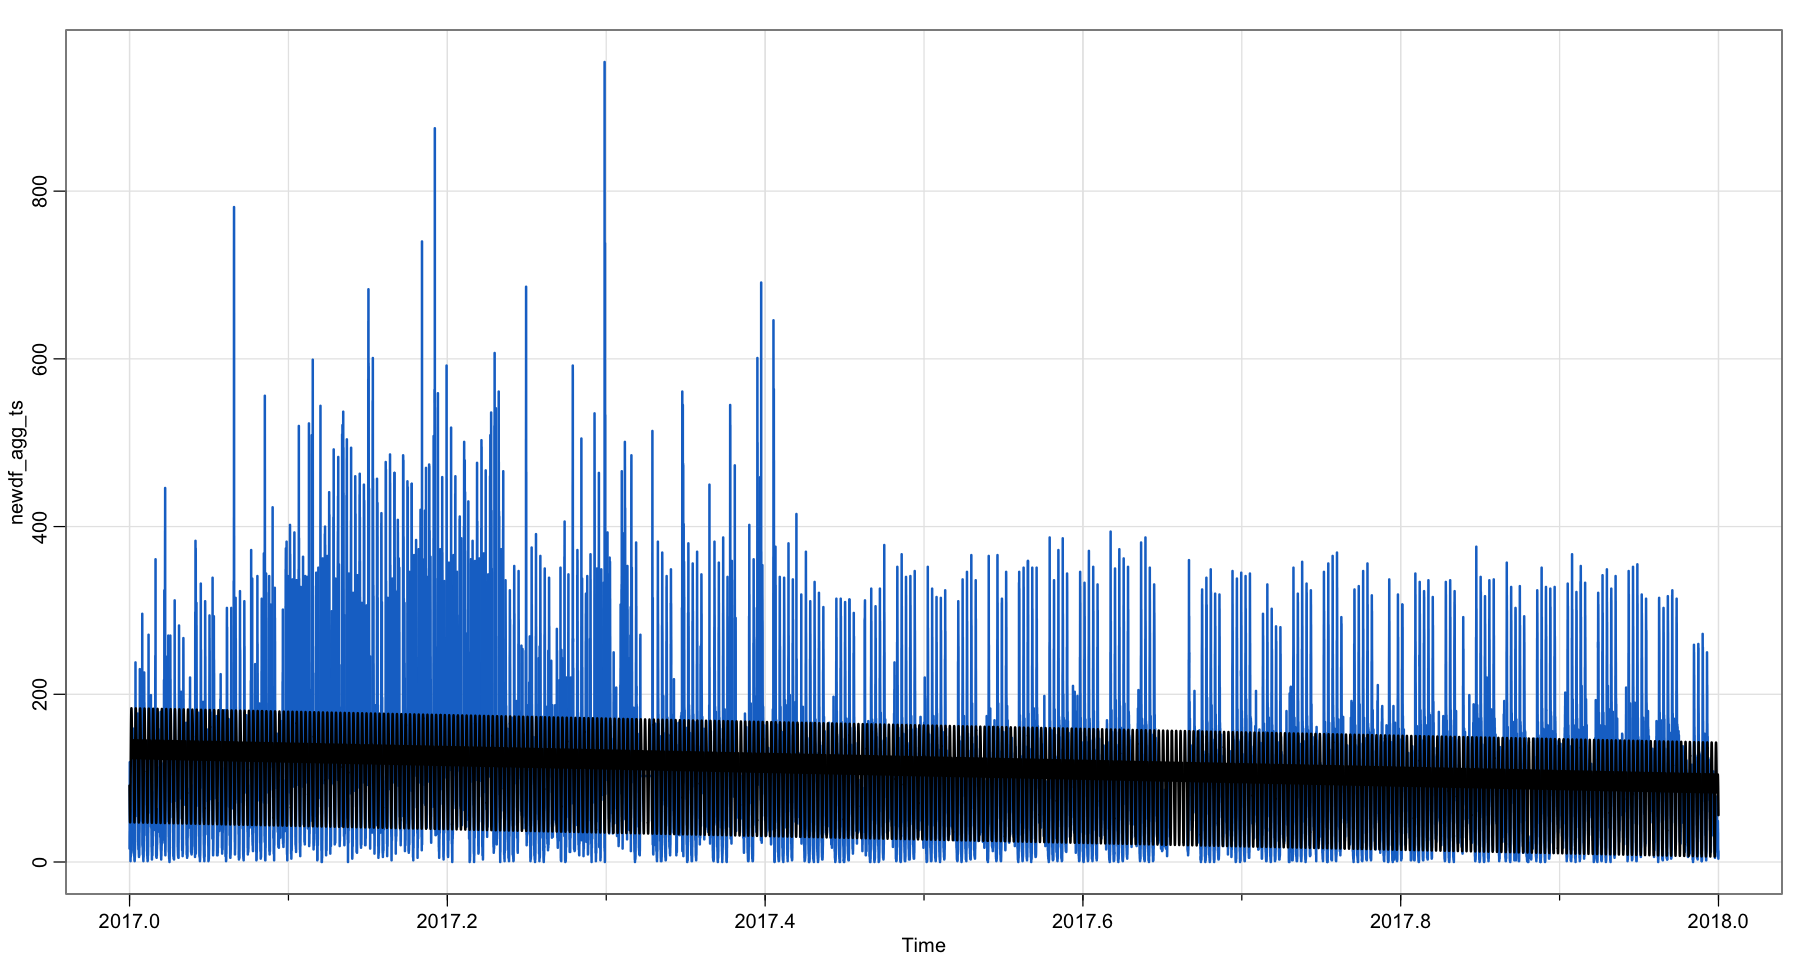

In [115]:
t = time(newdf_agg_ts)

# Creación de fit con las 3 frecuencias halladas
fit_df_ts_crop = lm(newdf_agg_ts ~ t + cos(2*pi*f1*t)+sin(2*pi*f1*t)+cos(2*pi*f2*t)+sin(2*pi*f2*t))

summary(fit_df_ts_crop)

adjustment_fit_df_ts_crop = ts(fitted(fit_df_ts_crop), start=2017, freq=freq/3)
tsplot(newdf_agg_ts, col=4, lwd=2)
lines(adjustment_fit_df_ts_crop, lwd=2)

# Residuals del ajuste
residuals_fit = residuals(fit_df_ts_crop)

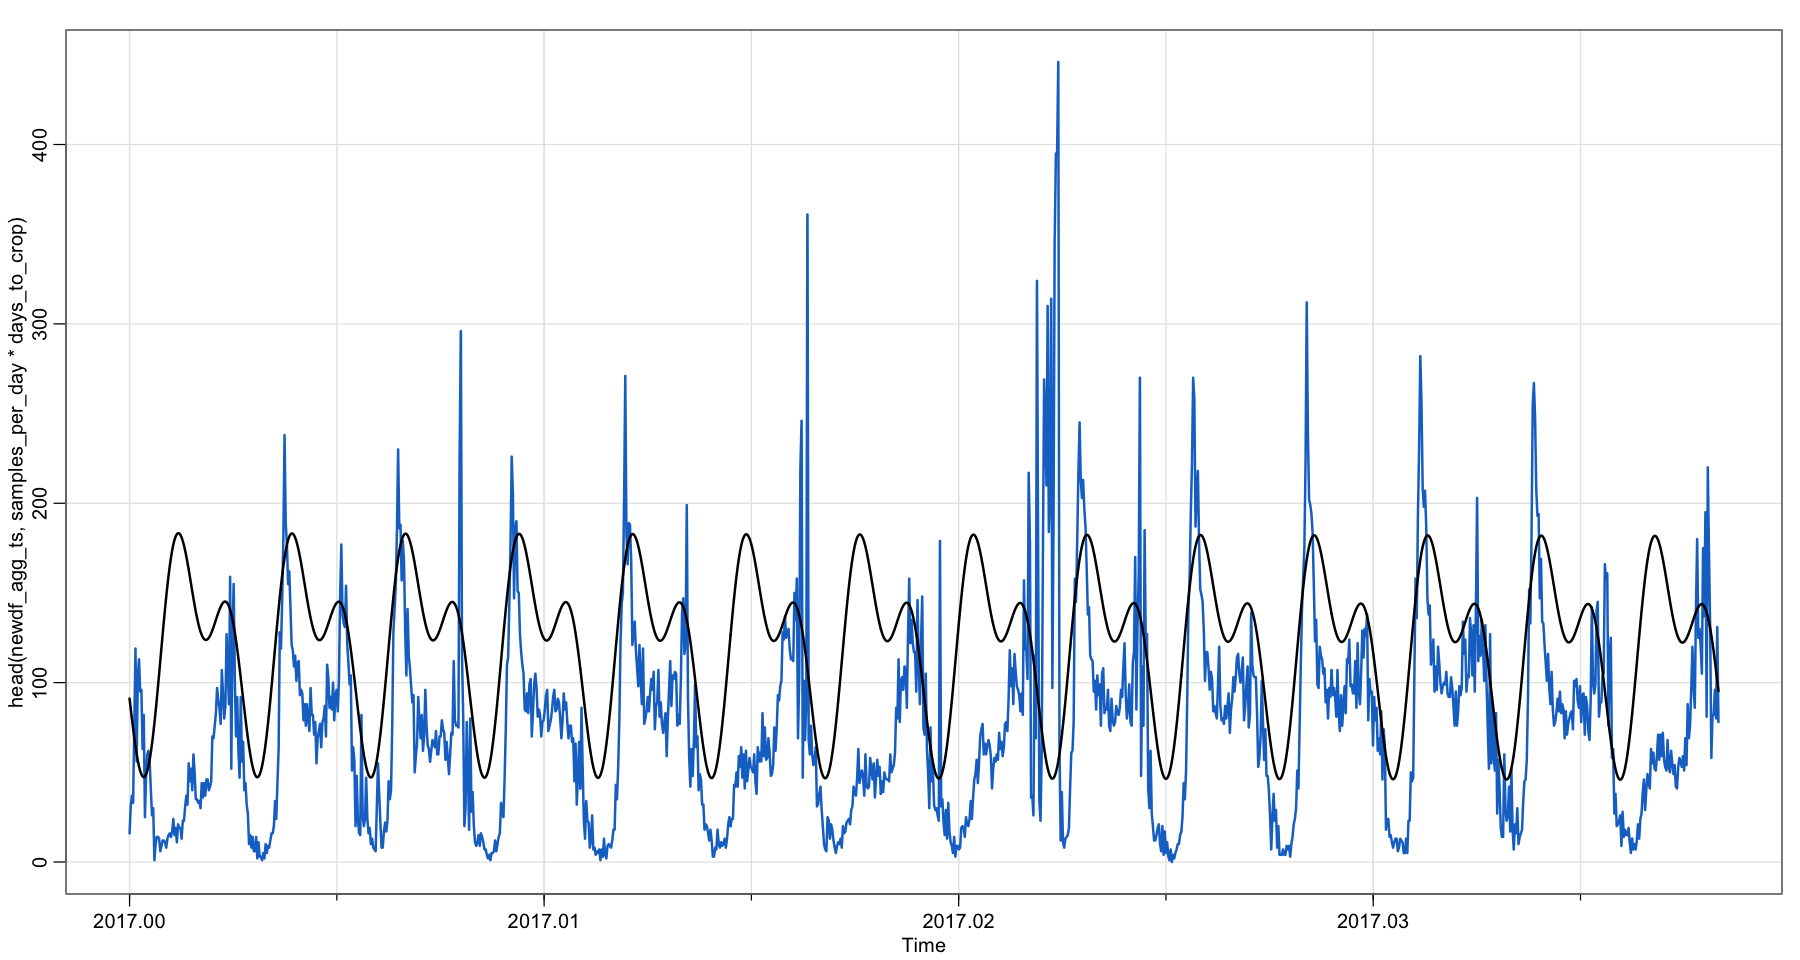

In [116]:
tsplot(head(newdf_agg_ts, samples_per_day*days_to_crop), col=4, lwd=2)
lines(head(adjustment_fit_df_ts_crop, samples_per_day*days_to_crop), lwd=2)

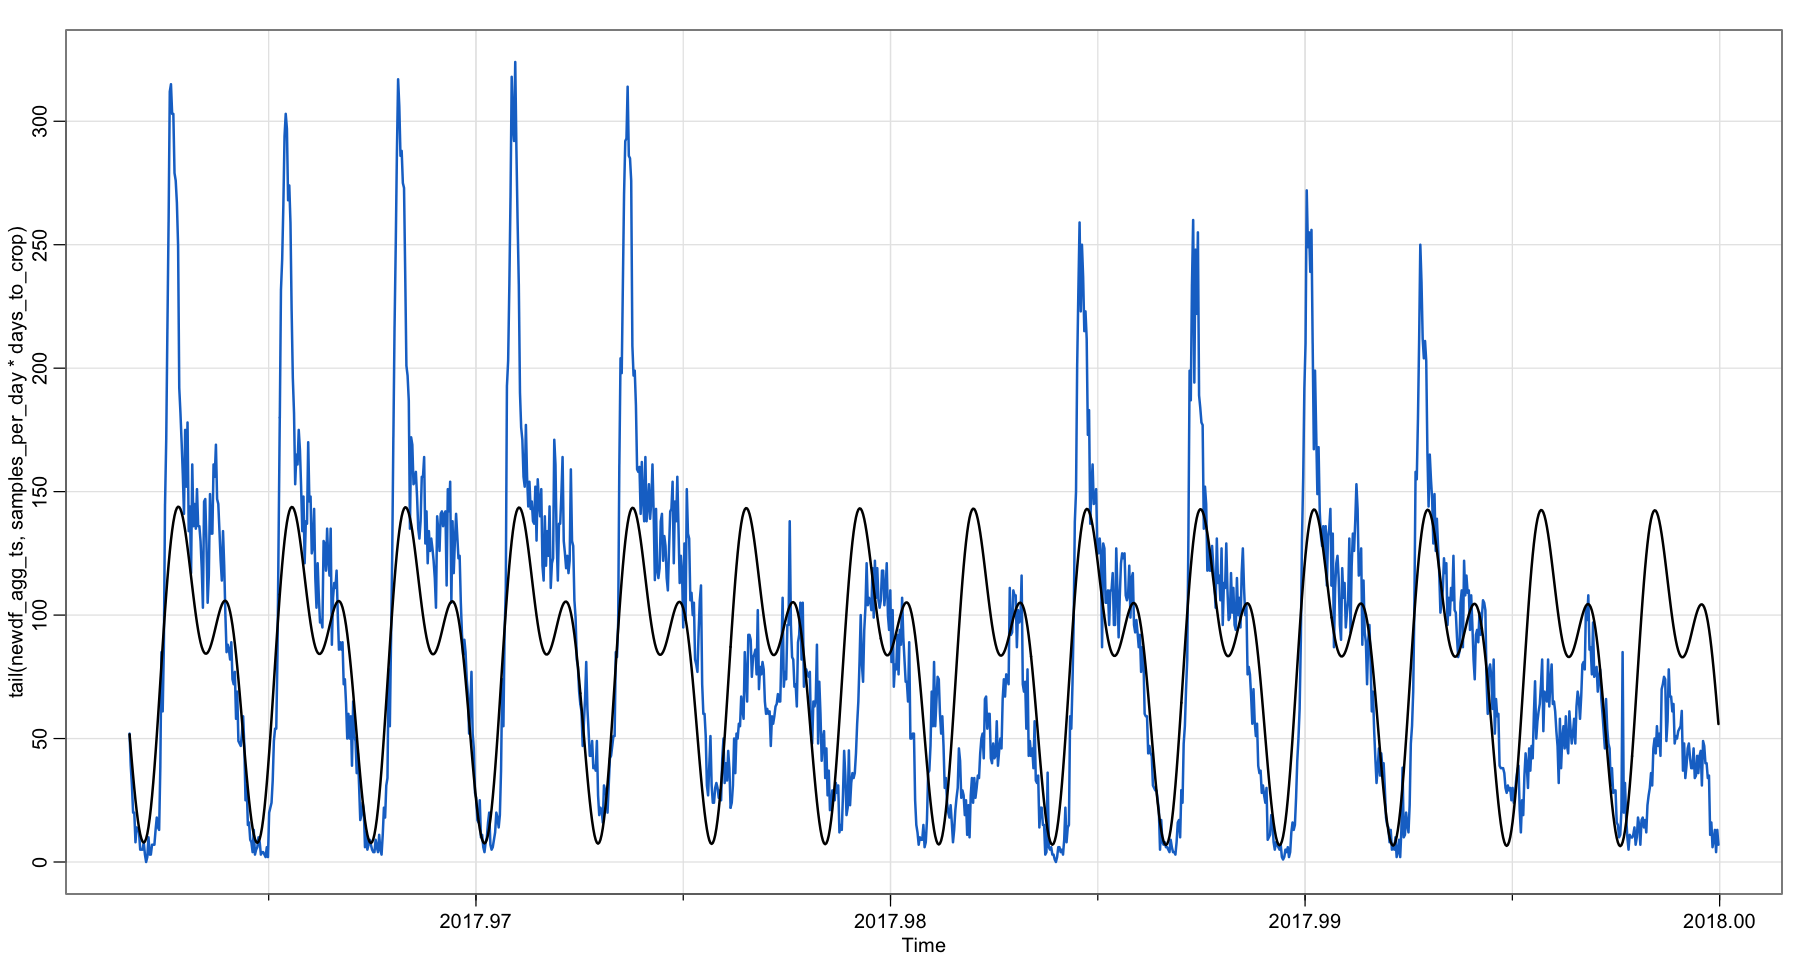

In [117]:
tsplot(tail(newdf_agg_ts, samples_per_day*days_to_crop), col=4, lwd=2)
lines(tail(adjustment_fit_df_ts_crop, samples_per_day*days_to_crop), lwd=2)

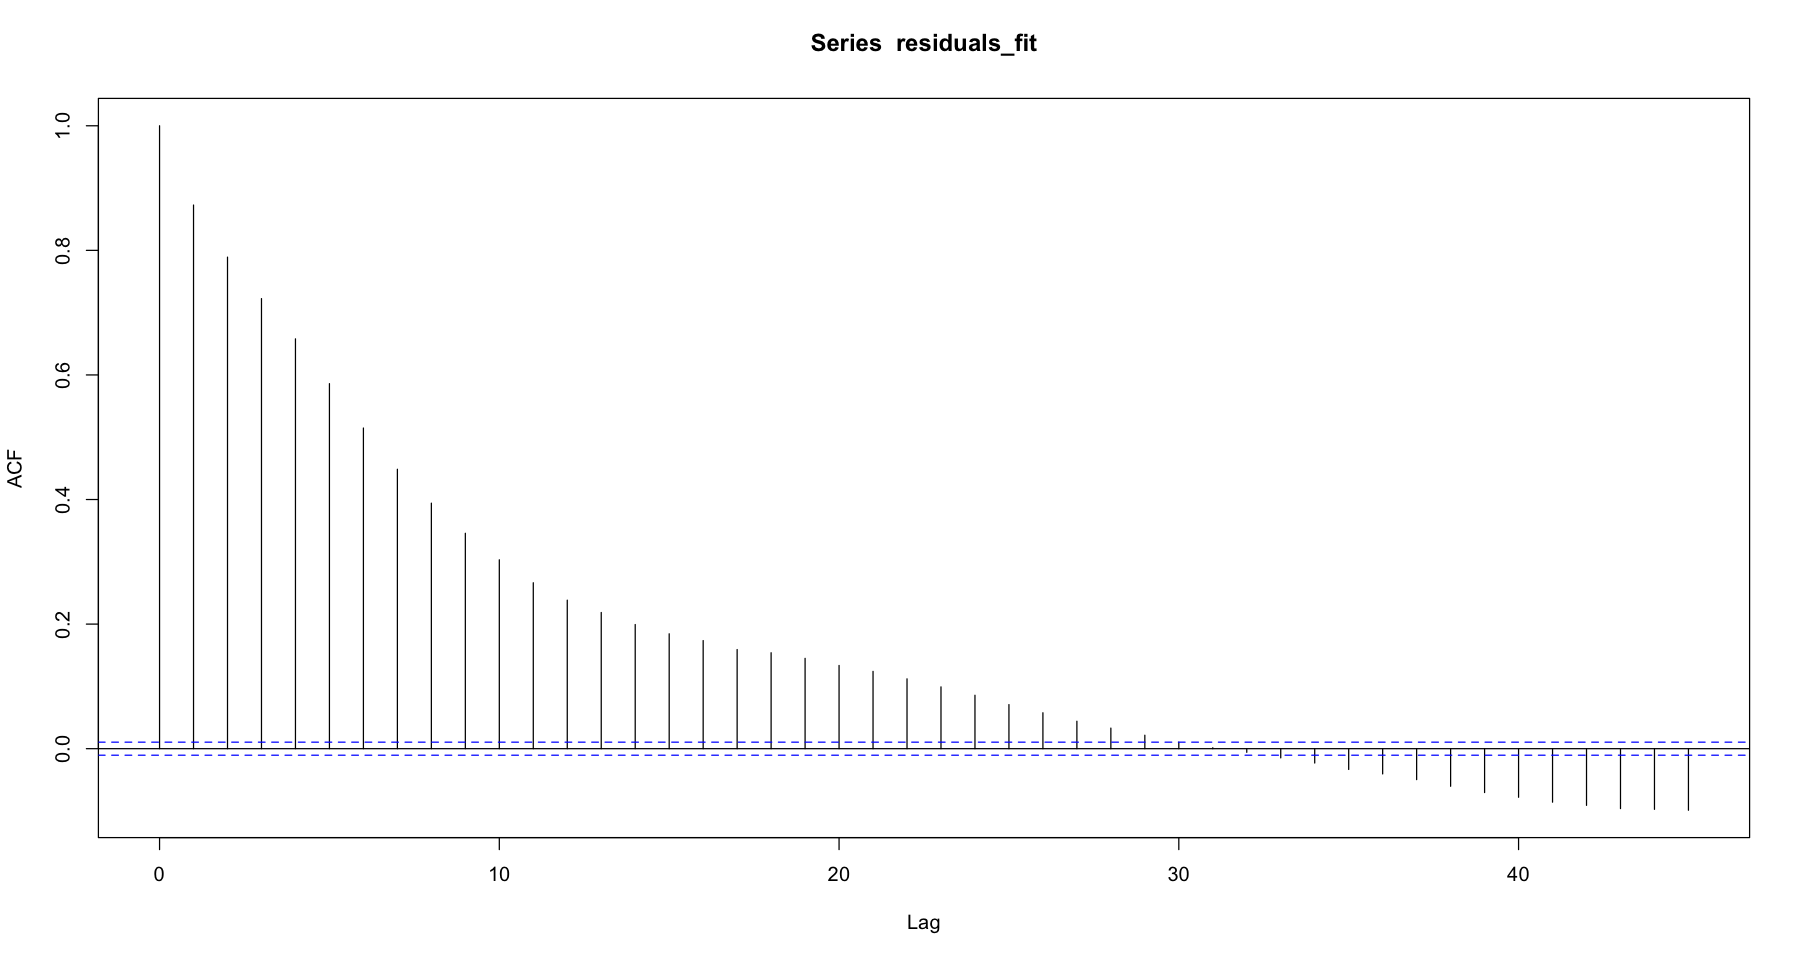

In [103]:
acf(residuals_fit)

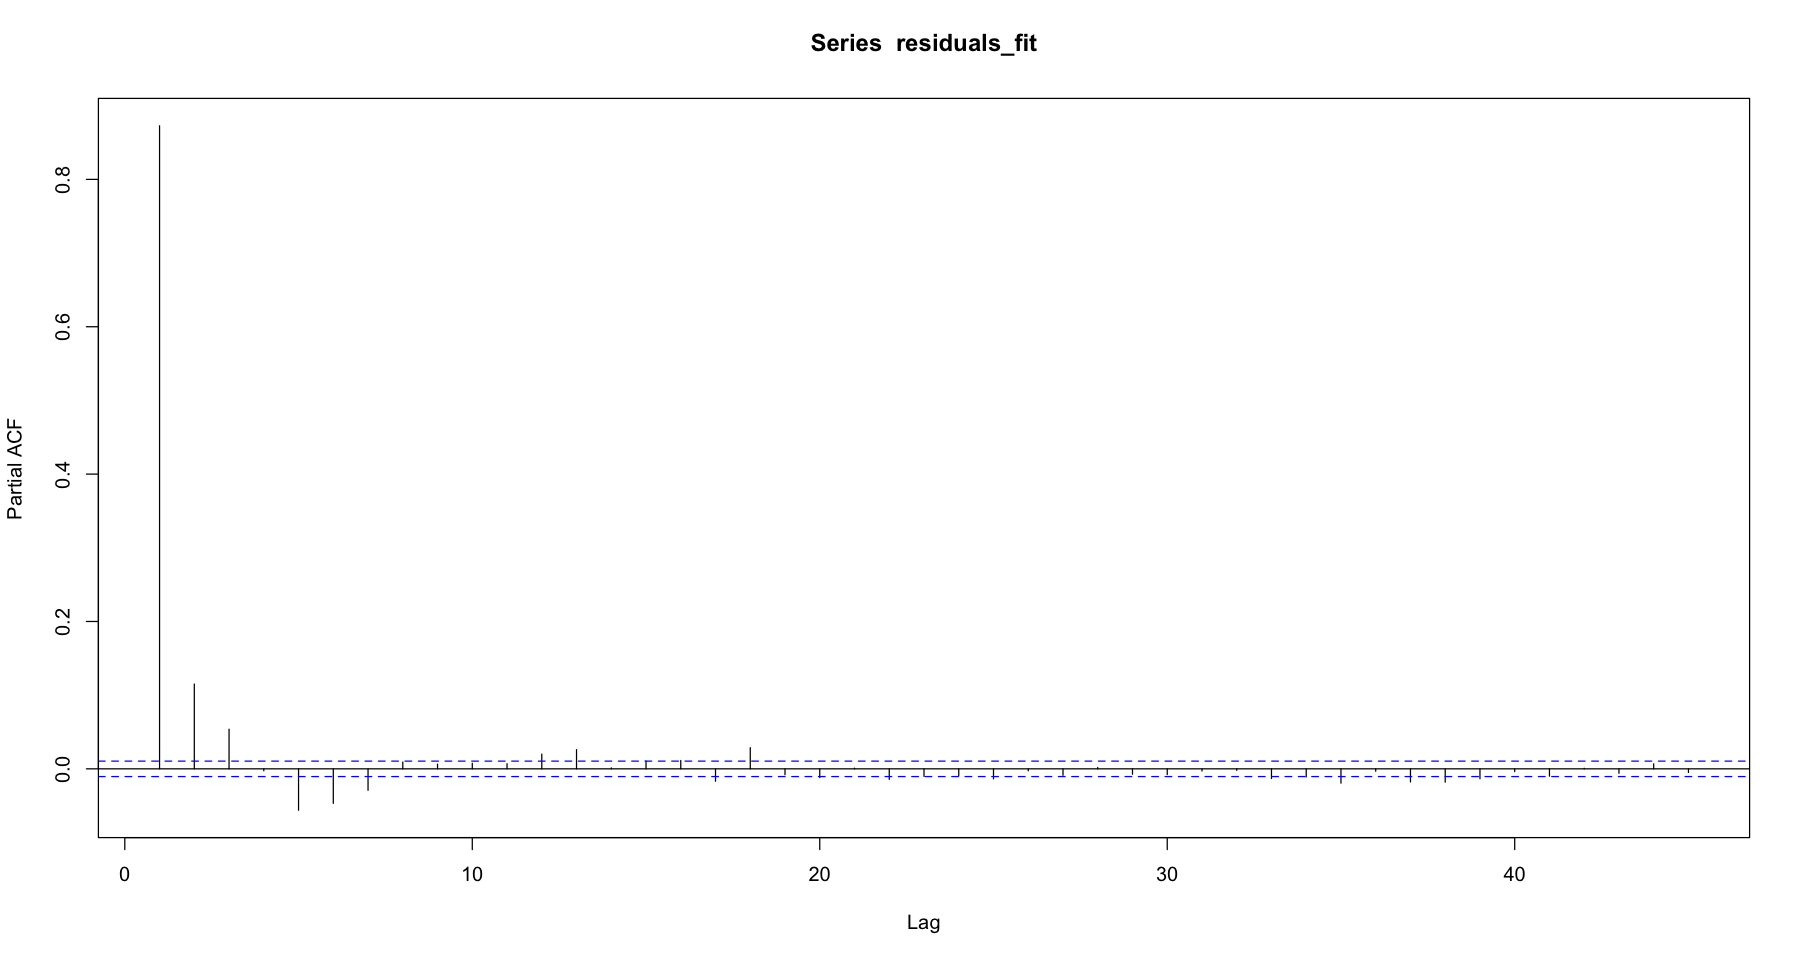

In [104]:
pacf(residuals_fit)

In [105]:
# Auto ARIMA con Seasonal
autoarima = auto.arima(ts, seasonal = TRUE)
ajuste_autoarima = ts(fitted(autoarima), start=2017, freq=freq)
summary(autoarima)
residuals_autoarima = residuals(autoarima)

Series: ts 
ARIMA(3,1,1) 

Coefficients:
         ar1     ar2     ar3      ma1
      0.2764  0.0210  0.0139  -0.6985
s.e.  0.0097  0.0051  0.0044   0.0092

sigma^2 = 156.5:  log likelihood = -404891.6
AIC=809793.2   AICc=809793.2   BIC=809841

Training set error measures:
                      ME     RMSE      MAE  MPE MAPE MASE         ACF1
Training set 0.001760682 12.51049 7.348122 -Inf  Inf  NaN 0.0003194669

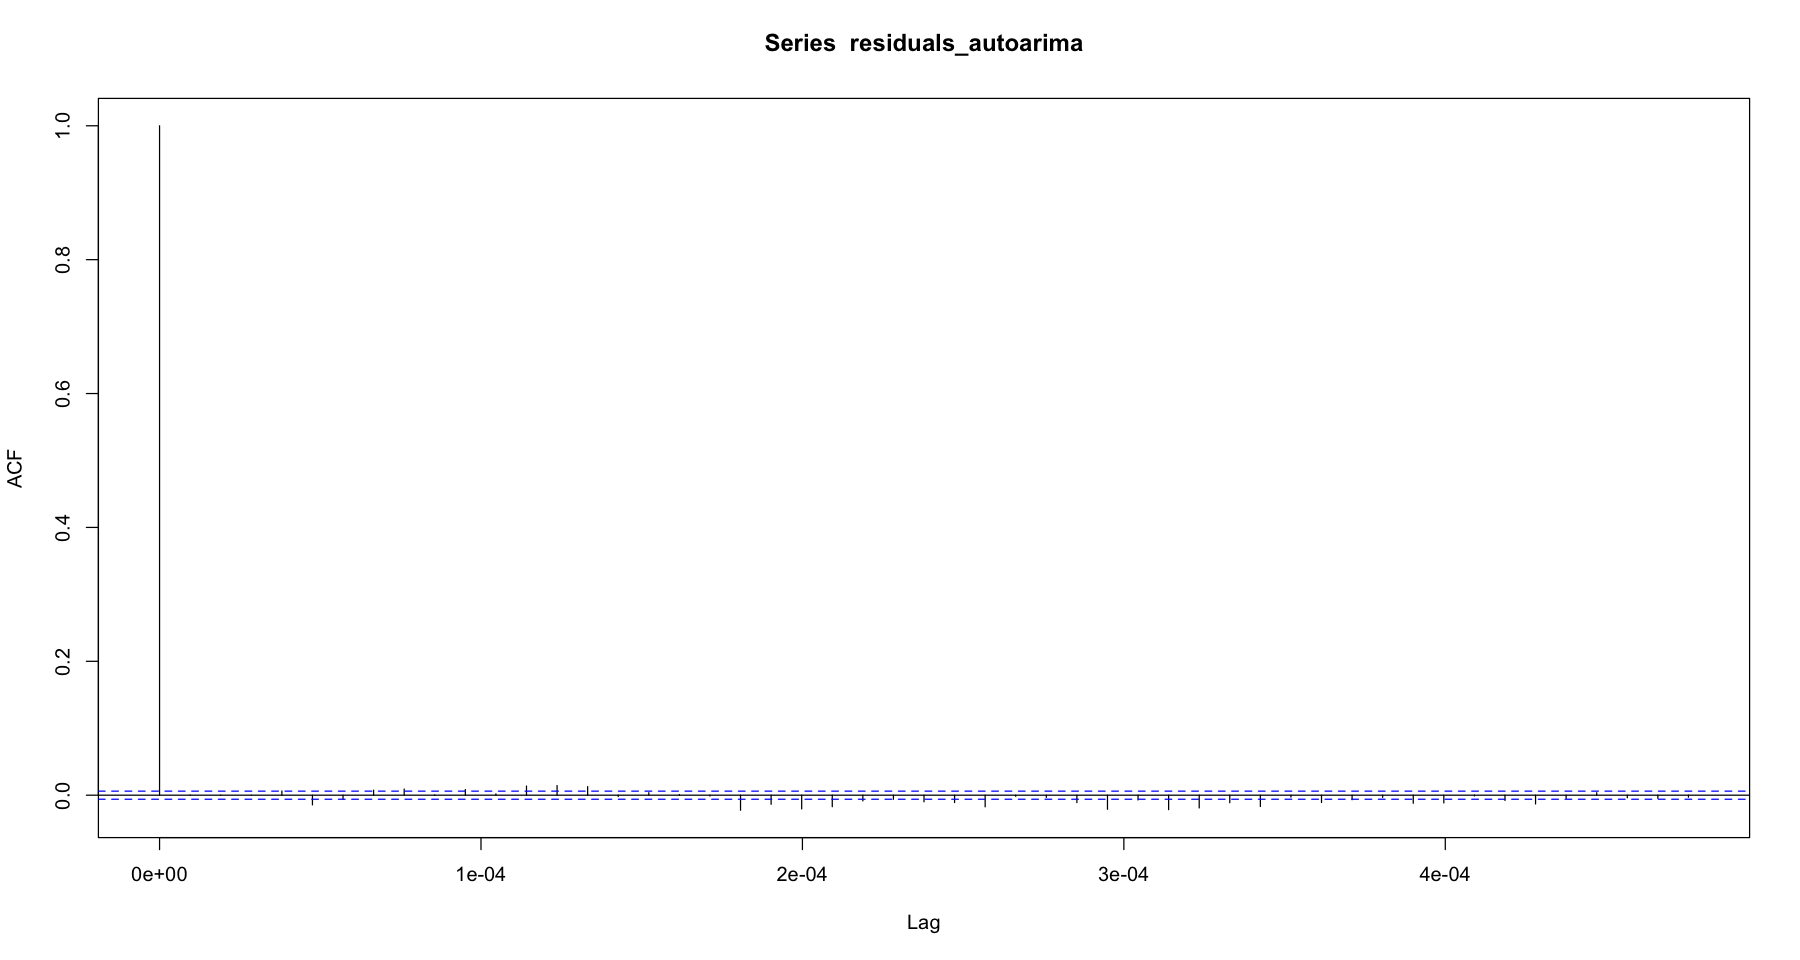

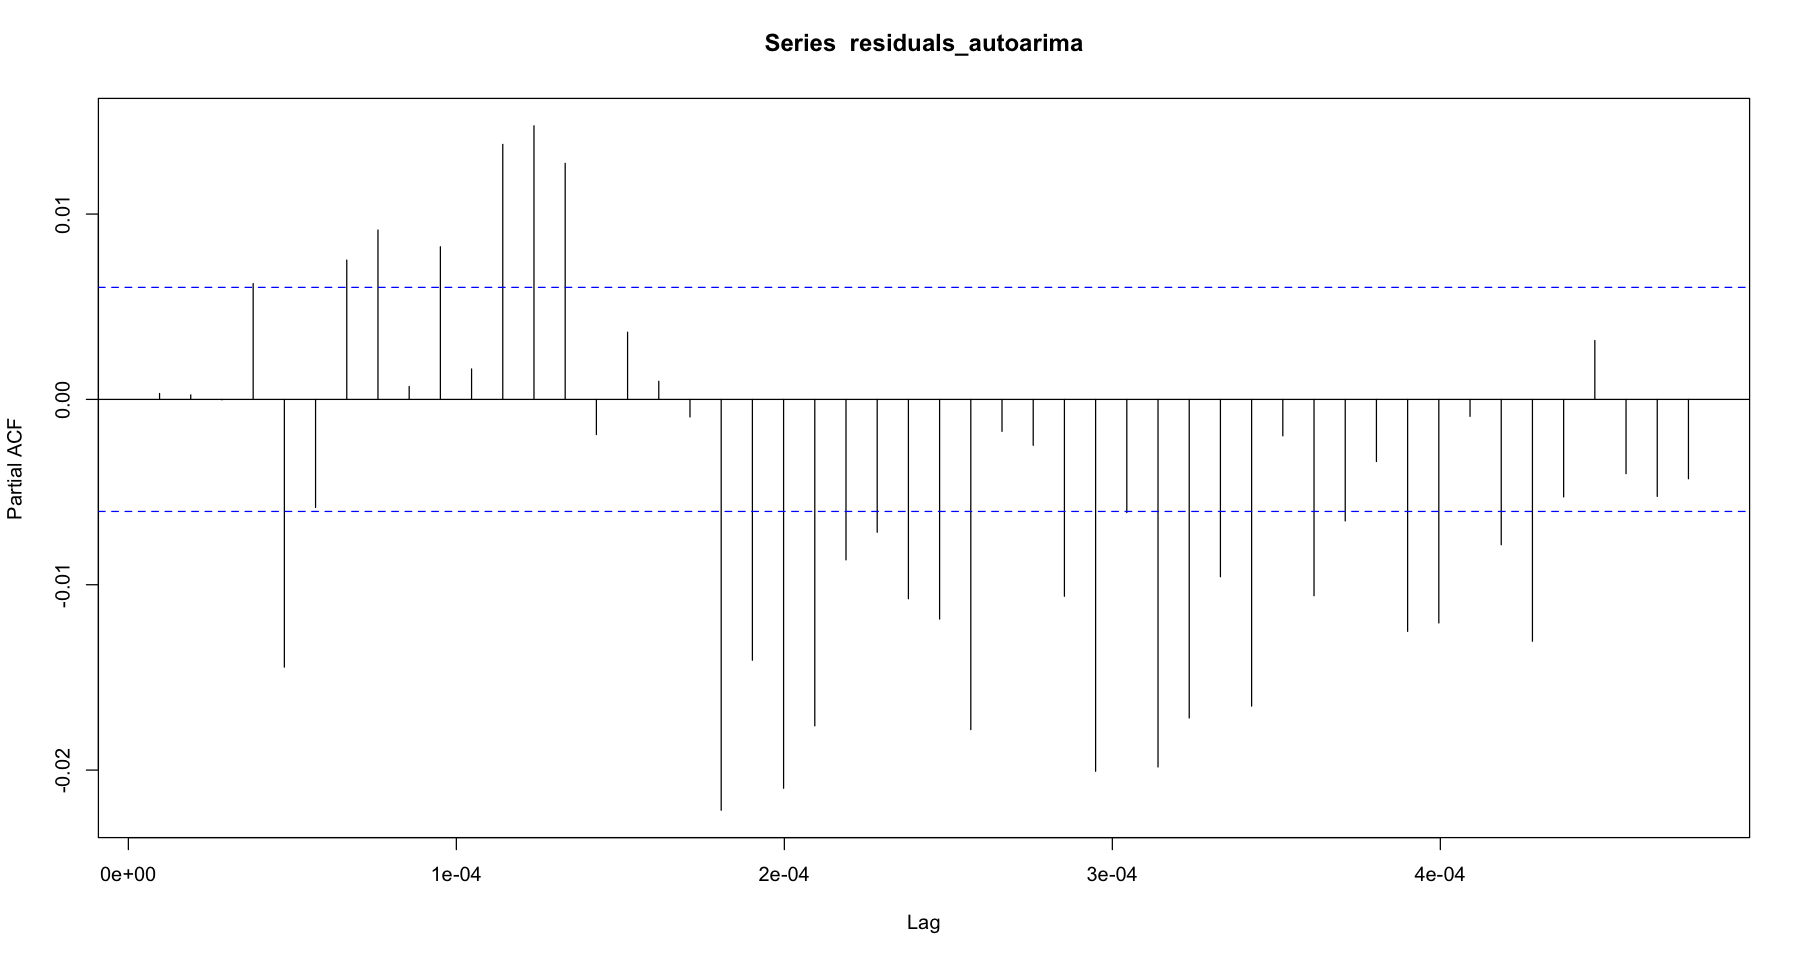

In [106]:
acf(residuals_autoarima, na.action = na.pass)
pacf(residuals_autoarima, na.action = na.pass)

In [107]:
# Ajuste de ARIMA de AR 2 con Season 1
arima_fit = Arima(df_ts, order=c(2,0,0), seasonal = c(1,0,0), include.mean = FALSE)
summary(arima_fit)
residuals_arima_fit = residuals(arima_fit)
ajuste_arima = ts(fitted(arima_fit), start=2017, freq=freq)

ERROR: Error in Arima(df_ts, order = c(2, 0, 0), seasonal = c(1, 0, 0), include.mean = FALSE): object 'df_ts' not found
